This script is designed to clean our data since there's repeat images

In [1]:
%pip install git+https://github.com/cleanlab/cleanvision.git
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import shutil
import cv2
import pandas as pd    
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from cleanvision.imagelab import Imagelab

def get_title(fpath):
    title=''
    split=fpath.split('/')
    for k in range(4, len(split)):
        title=title + split[k]+'/'
    return title

def resize_img(img):
    img_height=150
    img_width=int((img_height/img.shape[0])* img.shape[1])    
    img=cv2.resize(img, (img_width, img_height))   
    return img
    

def show_dups(dups, length, sdir): 
    height=int ((length +1)*4)
    plt.figure(figsize=(15, height))# width, height
    for i in range(length):
        f1path=dups[i][0]
        f2path=dups[i][1]
        img1=cv2.imread(f1path)
        img1=resize_img(img1)
        img1=cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2=cv2.imread(f2path)
        img2=resize_img(img2)
        img2=cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        j= i*2
        plt.subplot(length,2,j+1)               
        title=f1path.replace(sdir, '')
        plt.title(title, color='blue', fontsize=14)
        plt.axis('off')
        plt.imshow(img1)
        plt.subplot(length,2,j+2)           
        title=f2path.replace(sdir, '')
        plt.title(title,color='blue', fontsize=14)
        plt.axis('off')
        plt.imshow(img2)
    plt.show()
    
def show_images(paths, count):
    height=int((count+1))    
    plt.figure(figsize=(15, height))
    for i in range(count):
        fpath=paths[i]
        img=cv2.imread(fpath)
        shape=img.shape
        imgh=150
        imgw=int(imgh*shape[1]/shape[0])        
        img=cv2.resize(img, (imgw, imgh))
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        rows=int(count/4) +1        
        plt.subplot(rows, 4, i+1)        
        plt.axis('off')
        title=get_title(fpath)
        plt.title(title, color='blue', fontsize=10)
        plt.imshow(img)
    plt.show()
    
def print_pairs(plist, title, sd, count):
    print('{0:^40s}{1:^40s}'.format('Original Image', title))
    for i in range(count):
        e=plist[i]
        ed0=e[0].replace(sd, '')
        ed1=e[1].replace(sd, '')
        print ('{0:^40s}{1:^40s}'.format(ed0, ed1))

def analyze_dataset(sdir):    
    slength=len(sdir)
    imagelab = Imagelab(sdir)
    imagelab.find_issues()
    #imagelab.report()
    print(imagelab.issue_summary)
    delete_list=[]
    
    exact_duplicates=list(imagelab.info['exact_duplicates']['sets'])
    length=len(exact_duplicates)
    if length == 0:
        print('No duplicate images were found')
    else:
        dup_count=0
        plist=[]
        for i, ed in enumerate(exact_duplicates):
            lengthp=len(ed)       
            for j in range(1, lengthp):
                plist.append([ed[0], ed[j]])
                dup_count += 1        
        print('there are ', dup_count, ' pairs of duplicate images, enter an integer for how many to print, enter 0 for no print out')
        ans=int(input(' '))
        if ans !=0:            
            print_pairs(plist, 'duplicate image', sdir, ans)
        ans=int(input(' enter an integer for how many duplicate pairs to plot, enter 0 for no plot'))
        if ans != 0:
            show_dups( plist, ans, sdir)            
        print('enter D to delete all exact duplicates or press Enter to not delete')
        ans=input(' ')
        if ans == 'D' or ans == 'd':
            for i, ed in enumerate(exact_duplicates):
                lengthp=len(ed) 
                for j in range(1, lengthp):
                    if ed[j] not in delete_list:
                        delete_list.append(ed[j])

    near_duplicates=list(imagelab.info['near_duplicates']['sets'])
    length=len(near_duplicates)
    if length == 0:
        print('No near duplicate images were found')
    else:
        dup_count=0
        plist=[]
        for i, ed in enumerate(near_duplicates):
            lengthp=len(ed)       
            for j in range(1, lengthp):
                plist.append([ed[0], ed[j]])
                dup_count += 1        
        print('there are ', dup_count, ' pairs of near duplicate images, enter an integer for how many to print, enter 0 for no print out')
        ans=int(input(' '))
        if ans !=0:            
            print_pairs(plist, 'near duplicate image', sdir, ans)
        ans=int(input(' enter an integer for how many near duplicate pairs to plot, enter 0 for no plot'))
        if ans != 0:
            show_dups( plist, ans, sdir) 
        print('enter D to delete all near duplicates or press Enter to not delete') 
        ans=input(' ')
        if ans == 'D' or ans == 'd':
            for i, ed in enumerate(near_duplicates):
                lengthp=len(ed) 
                for j in range(1, lengthp):
                    if ed[j] not in delete_list:
                        delete_list.append(ed[j])
    to_light = imagelab.issues[imagelab.issues["is_light_issue"] == True].sort_values(by=['light_score']).index.tolist()
    length=len(to_light)
    if length == 0:
        print('There are no images that are to light')
    else:
        ans=input('Enter P to print all ', length, ' to light images or press enter to not print ')
        if ans == 'P' or ans == 'p':
            for f in to_light:
                print (f)
        ans=int(input(' enter an integer for how many to light images to plot, enter 0 for no plot'))
        if ans != 0:
            show_images(to_light, ans)        
        ans=input('Enter D to delete the ', length, ' to light images, to not delete press Enter ' )
        if ans == 'D' or ans == 'd':
            for imgpath in to_light:
                if imgpath not in delete_list:
                    delete_list.append(imgpath)

    to_dark = imagelab.issues[imagelab.issues["is_dark_issue"] == True].sort_values(by=['dark_score']).index.tolist()
    length=len(to_dark)
    if length == 0:
        print('There are no images that are to dark')
    else:
        print('there are ', length, ' to dark images, enter an integer for how many to print, enter 0 for no print out')
        ans=int(input(' '))
        if ans !=0:
            for i in range (ans):
              print(to_dark[i])
                
        ans=int(input(' enter an integer for how many to dark images to plot, enter 0 for no plot'))
        if ans != 0:
            show_images(to_dark, ans)  
        print('Enter D to delete the ', length, ' to dark images, to not delete press Enter ')
        ans=input(' ' )
        if ans == 'D' or ans == 'd':
            for imgpath in to_dark:
                if imgpath not in delete_list:
                    delete_list.append(imgpath)

    blurry_images = imagelab.issues[imagelab.issues["is_blurry_issue"] == True].sort_values(by=['blurry_score']).index.tolist()
    length=len(blurry_images)
    if length == 0:
        print('There are no blurry images ')
    else:
        print('there are ', length, ' blurry images, enter an integer for how many to print, enter 0 for no print out')
        ans=int(input(' '))
        if ans !=0:
            for i in range (ans):
              print(blurry_images[i])
        ans=int(input(' enter an integer for how many to blurry images to plot, enter 0 for no plot'))
        if ans != 0:
            show_images(blurry_images, ans)  
        print('Enter D to delete all ', length, ' to blurry images, to not delete press Enter ')
        ans=input(' ' )
        if ans == 'D' or ans == 'd':
            for imgpath in blurry_images:
                if imgpath not in delete_list:
                    delete_list.append(imgpath)

    no_info = imagelab.issues[imagelab.issues["is_low_information_issue"] == True].sort_values(by=['low_information_score']).index.tolist()
    length=len(no_info)
    if length == 0:
        print('No  low information images were found')
    else:
        print('there are ', length, ' low information images, enter an integer for how many to print, enter 0 for no print out')
        ans=int(input(' '))
        if ans !=0:
            for i in range (ans):
              print(no_info[i])
        ans=int(input(' enter an integer for how many to low information images to plot, enter 0 for no plot'))
        if ans != 0:
            show_images(no_info, ans)  
        print('Enter D to delete all ', length, ' to low info images, to not delete press Enter ')
        ans=input(' ' )
        if ans == 'D' or ans == 'd':
            for imgpath in no_info:
                if imgpath not in delete_list:
                    delete_list.append(imgpath)
    print('*****  Data set processing is completed  *****')
    return delete_list

  Cloning https://github.com/cleanlab/cleanvision.git to /private/var/folders/26/7l8wl7vd46b9rlntc4gz7qtc0000gn/T/pip-req-build-gpt82nnv
  Running command git clone --filter=blob:none --quiet https://github.com/cleanlab/cleanvision.git /private/var/folders/26/7l8wl7vd46b9rlntc4gz7qtc0000gn/T/pip-req-build-gpt82nnv
  Resolved https://github.com/cleanlab/cleanvision.git to commit 4e44f4c5f2c16fae8268ee1ea6e4d7bb7d3b464e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


/Users/jesusbautista/repos/ReefClassifier/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Reading images from /Users/jesusbautista/repos/ReefClassifier/data/bleached_corals
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


100%|██████████| 485/485 [00:00<00:00, 500.59it/s]


Issue checks completed. 16 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
         issue_type  num_images
0  exact_duplicates           6
1   near_duplicates           5
2          odd_size           4
3            blurry           1
4              dark           0
5             light           0
6  odd_aspect_ratio           0
7   low_information           0
8         grayscale           0
there are  3  pairs of duplicate images, enter an integer for how many to print, enter 0 for no print out
             Original Image                         duplicate image             
/Users/jesusbautista/repos/ReefClassifier//6387206507_faa332cbc1_o.jpg/Users/jesusbautista/repos/ReefClassifier//6392167385_f94ecdf733_o.jpg
/Users/jesusbautista/repos/ReefClassifier//6398049615_c4626706d9_o.jpg/Users/jesusbautista/repos/ReefClassifier//7174750970_0dd3823402_o.jpg
/Users/jesusbautista/repos/ReefClassifier//8051294849_65bacafde8_o.jpg/Users/jesusbautista

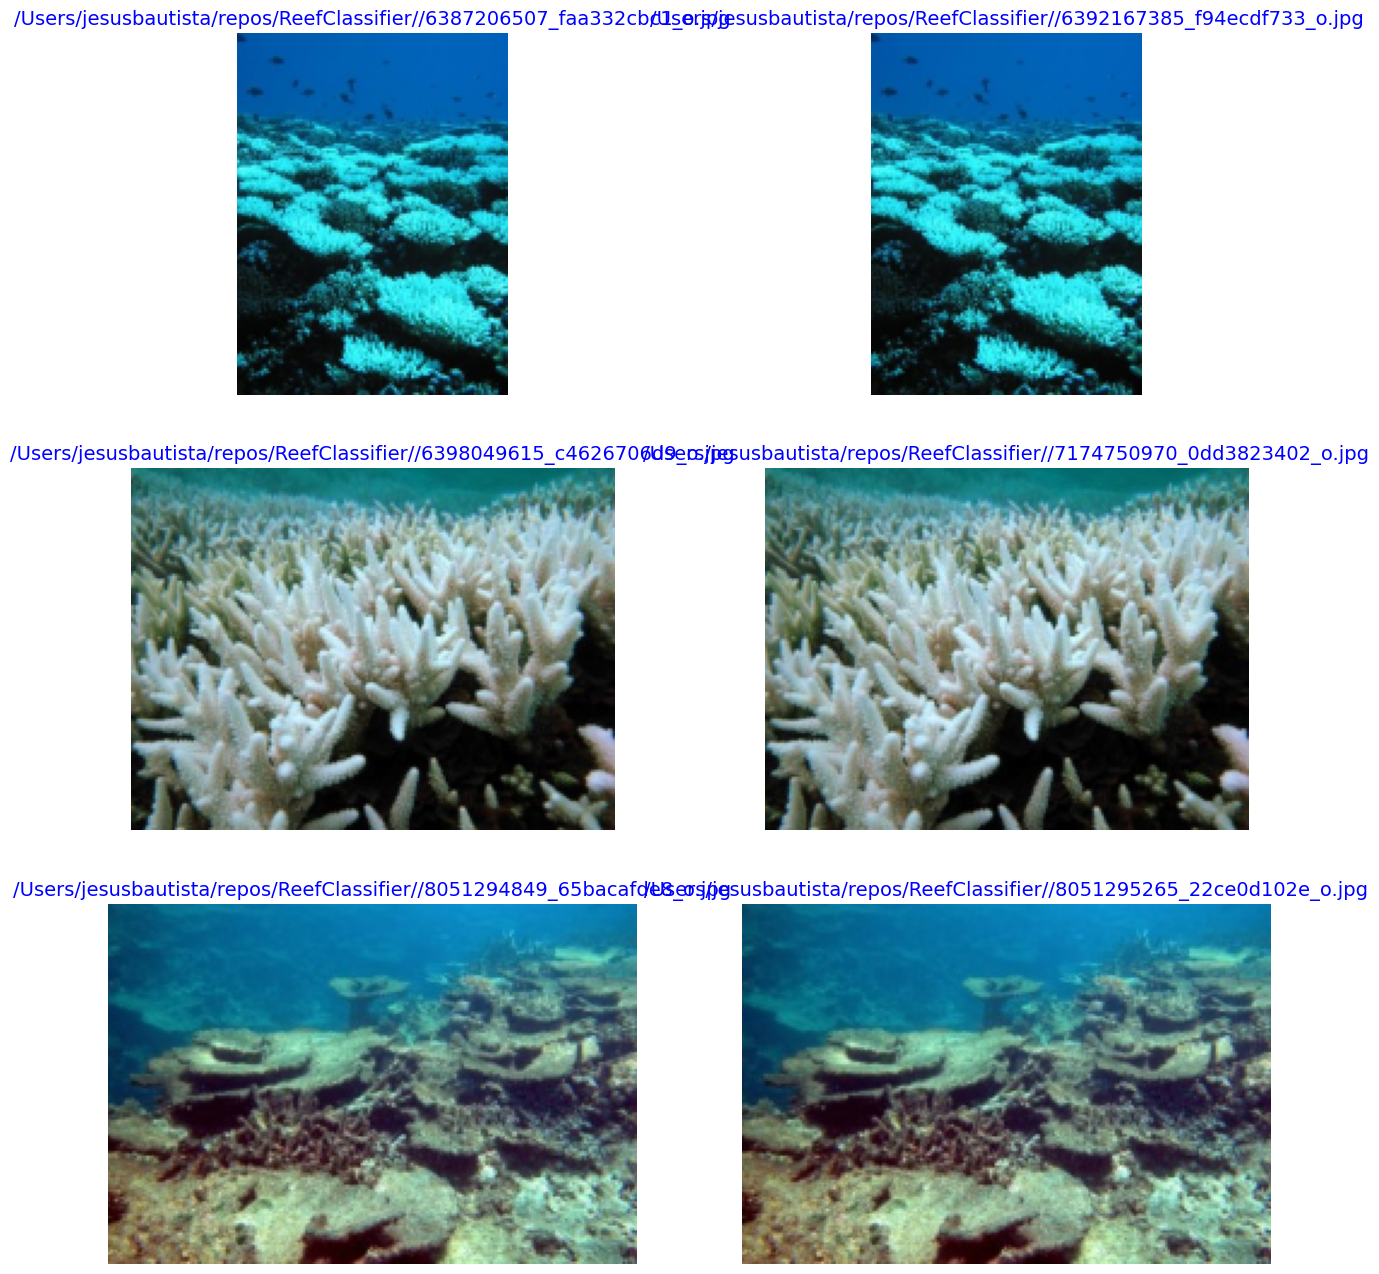

enter D to delete all exact duplicates or press Enter to not delete
there are  3  pairs of near duplicate images, enter an integer for how many to print, enter 0 for no print out
             Original Image                       near duplicate image          
/Users/jesusbautista/repos/ReefClassifier//14184579797_9df22c65b8_o.jpg/Users/jesusbautista/repos/ReefClassifier//5095123502_96243e475c_o.jpg
/Users/jesusbautista/repos/ReefClassifier//6398049615_c4626706d9_o.jpg/Users/jesusbautista/repos/ReefClassifier//7174750970_0dd3823402_o.jpg
/Users/jesusbautista/repos/ReefClassifier//6398049615_c4626706d9_o.jpg/Users/jesusbautista/repos/ReefClassifier//8051298662_3d04161c19_o.jpg


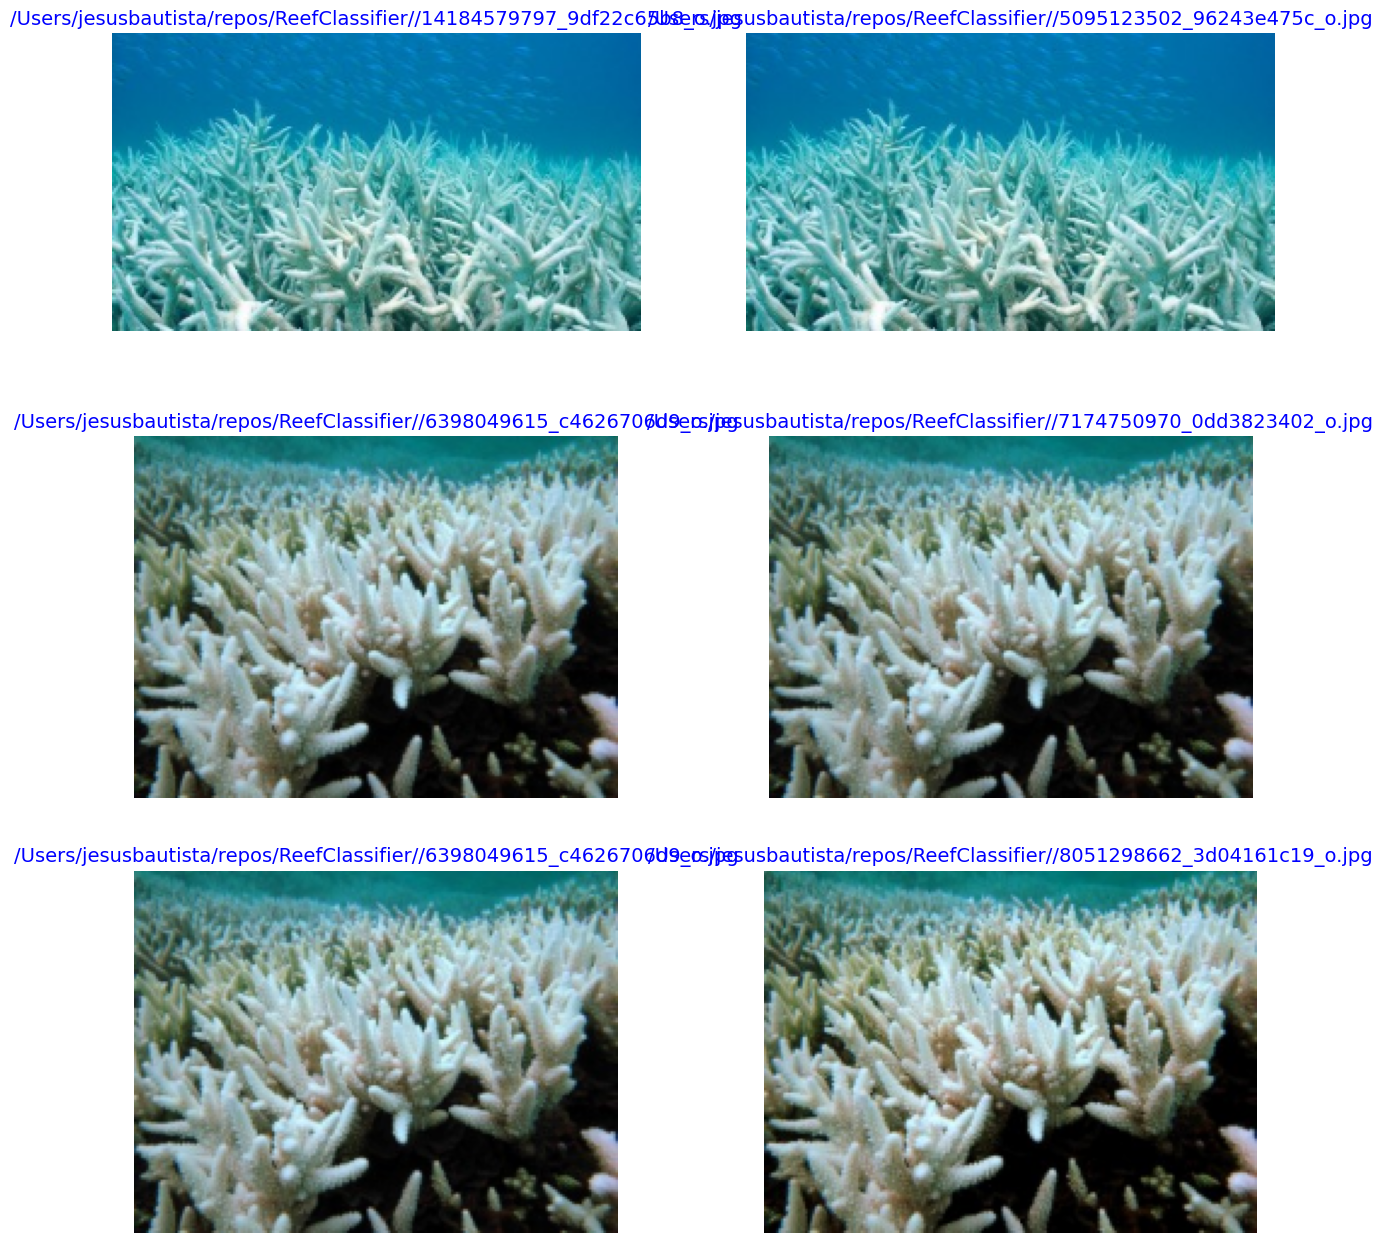

enter D to delete all near duplicates or press Enter to not delete
There are no images that are to light
There are no images that are to dark
there are  1  blurry images, enter an integer for how many to print, enter 0 for no print out
/Users/jesusbautista/repos/ReefClassifier/data/bleached_corals/14973511981_4cee187686_b.jpg


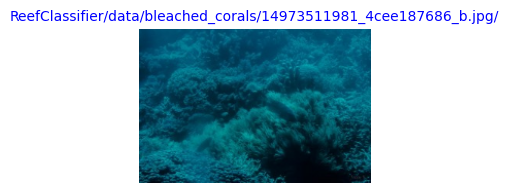

Enter D to delete all  1  to blurry images, to not delete press Enter 
No  low information images were found
*****  Data set processing is completed  *****


In [2]:
source_dir=r'data/bleached_corals'
delete_list=analyze_dataset(source_dir)

Reading images from /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


100%|██████████| 438/438 [00:00<00:00, 448.15it/s]


Issue checks completed. 20 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
         issue_type  num_images
0  exact_duplicates          12
1          odd_size           3
2   near_duplicates           3
3              dark           1
4            blurry           1
5             light           0
6  odd_aspect_ratio           0
7   low_information           0
8         grayscale           0
there are  6  pairs of duplicate images, enter an integer for how many to print, enter 0 for no print out
             Original Image                         duplicate image             
/Users/jesusbautista/repos/ReefClassifier//10479719064_929fa60800_o.jpg/Users/jesusbautista/repos/ReefClassifier//10829442286_2f4c92499a_o.jpg
/Users/jesusbautista/repos/ReefClassifier//14318242634_fce485d3fc_b.jpg/Users/jesusbautista/repos/ReefClassifier//14470460565_6f6145898b_b.jpg
/Users/jesusbautista/repos/ReefClassifier//3022783330_3f5fa1b7b2_o.jpg/Users/jesusbaut

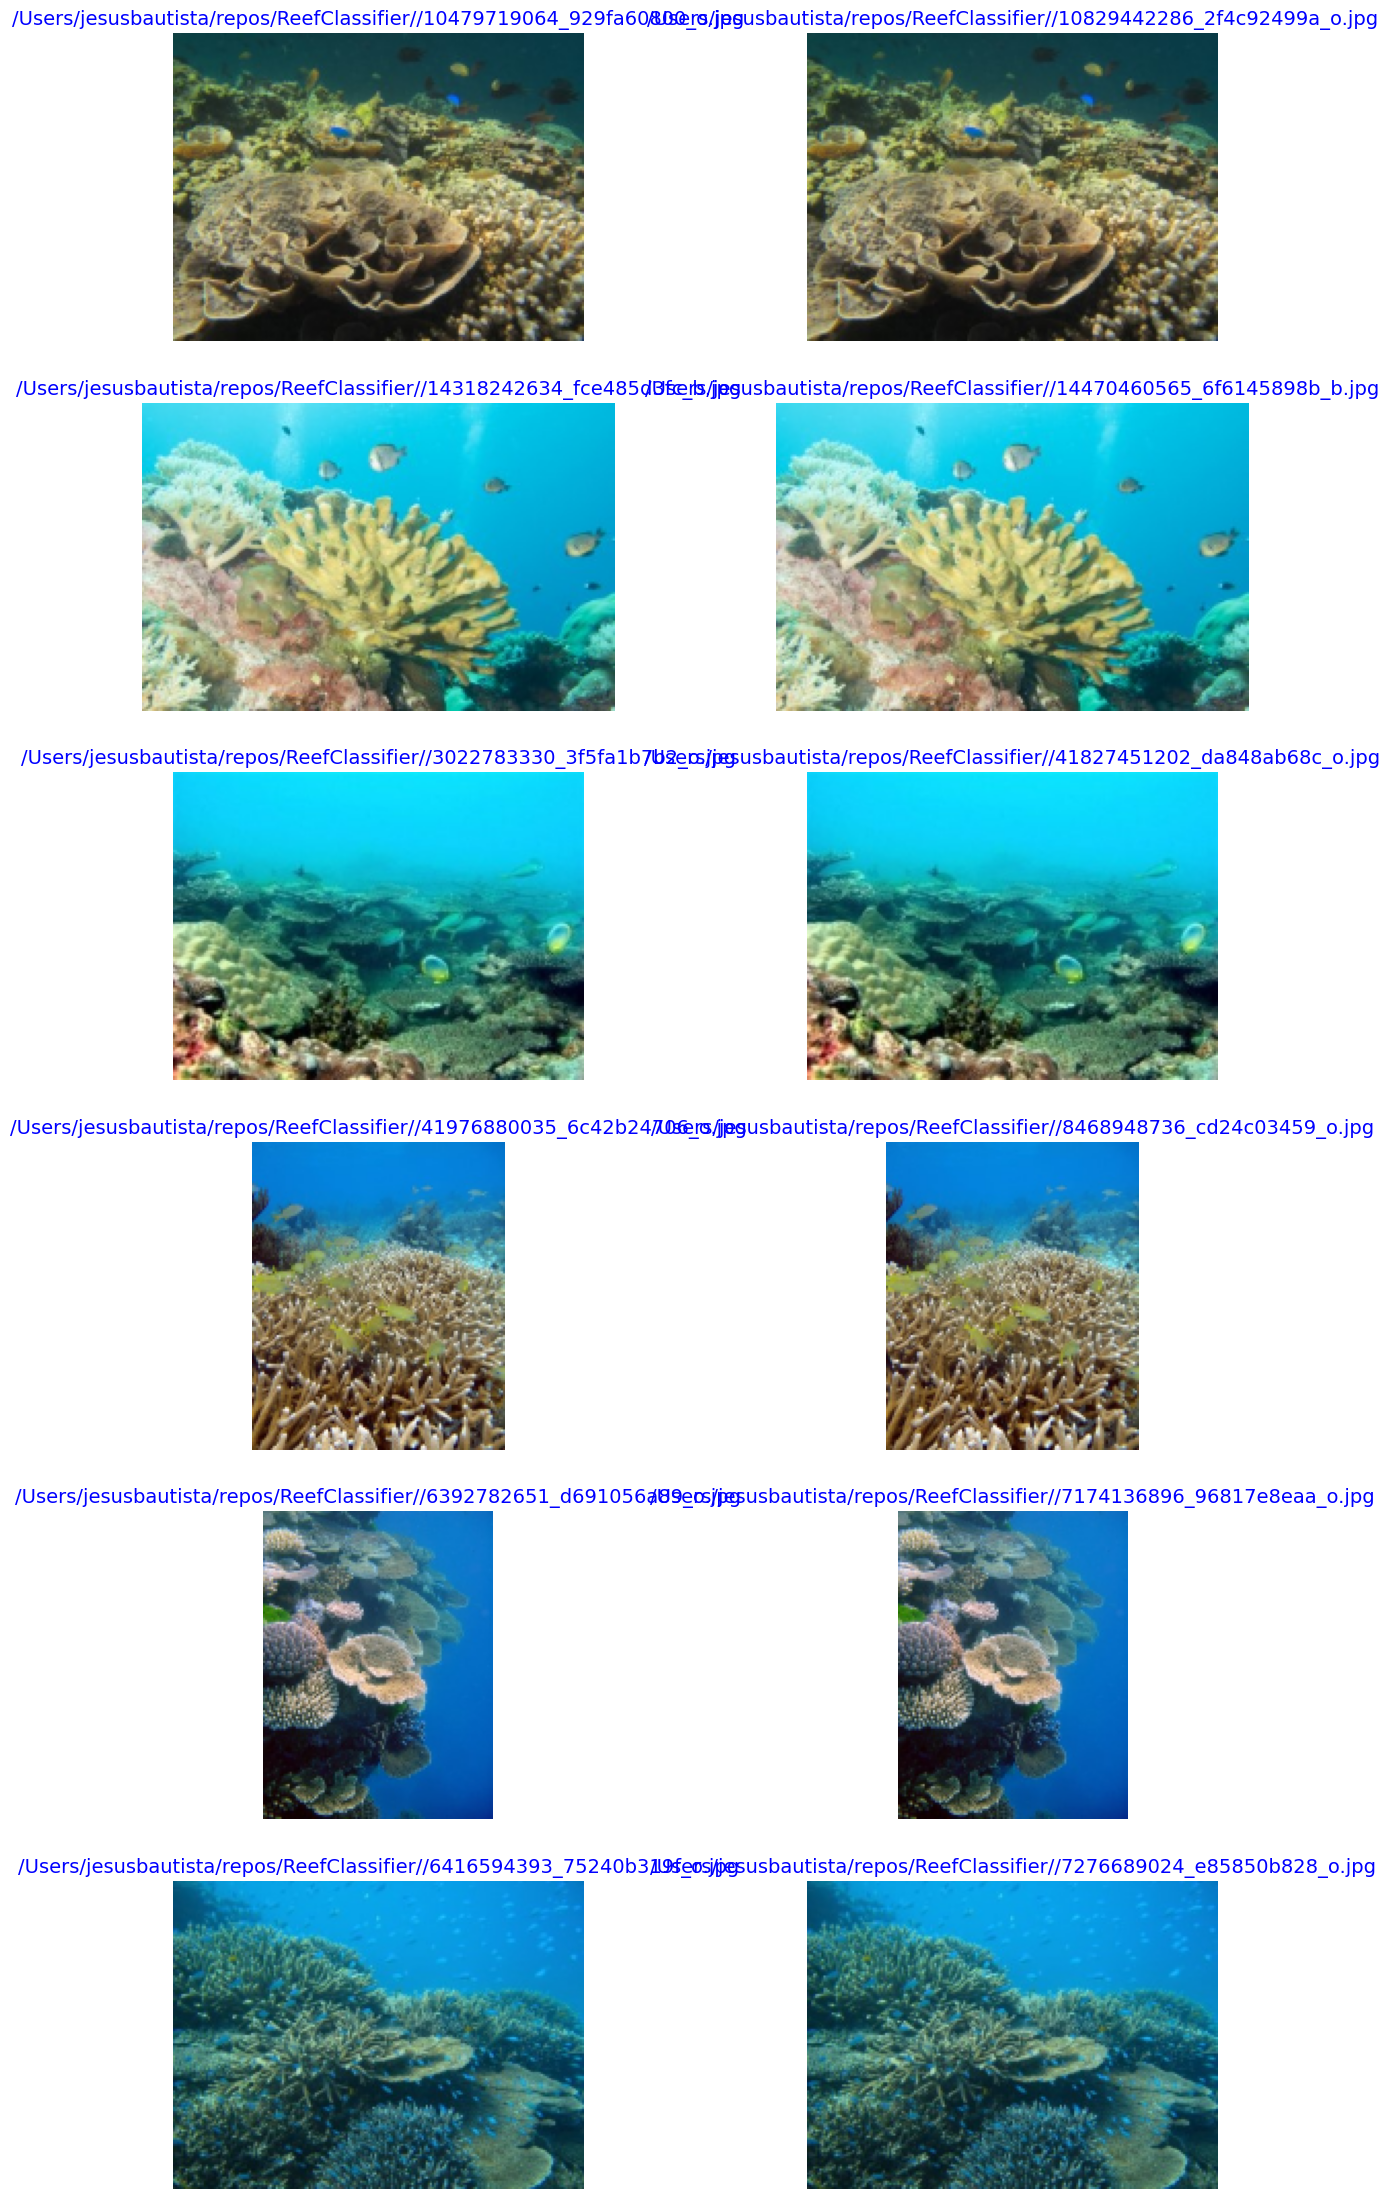

enter D to delete all exact duplicates or press Enter to not delete
there are  2  pairs of near duplicate images, enter an integer for how many to print, enter 0 for no print out
             Original Image                       near duplicate image          
/Users/jesusbautista/repos/ReefClassifier//6392167329_484ab2cfa4_o.jpg/Users/jesusbautista/repos/ReefClassifier//6392782651_d691056a89_o.jpg
/Users/jesusbautista/repos/ReefClassifier//6392167329_484ab2cfa4_o.jpg/Users/jesusbautista/repos/ReefClassifier//7174136896_96817e8eaa_o.jpg


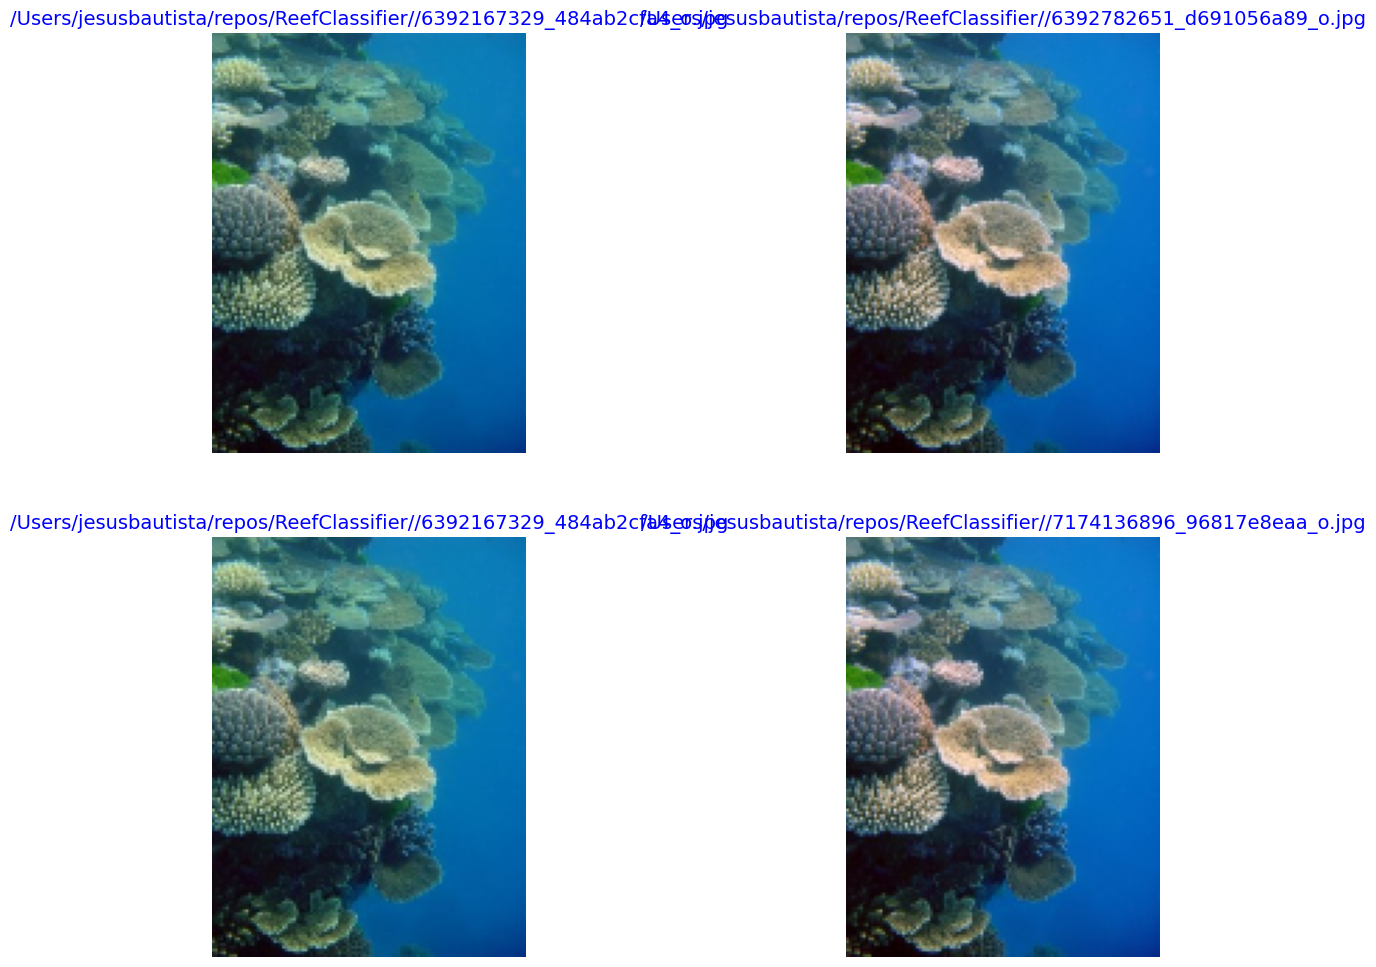

enter D to delete all near duplicates or press Enter to not delete
There are no images that are to light
there are  1  to dark images, enter an integer for how many to print, enter 0 for no print out
Enter D to delete the  1  to dark images, to not delete press Enter 
there are  1  blurry images, enter an integer for how many to print, enter 0 for no print out
Enter D to delete all  1  to blurry images, to not delete press Enter 
No  low information images were found
*****  Data set processing is completed  *****


In [7]:
source_dir=r'data/healthy_corals'
delete_list=analyze_dataset(source_dir)

In [8]:
print(os.listdir('/Users/jesusbautista/repos/ReefClassifier'))
source_dir = 'data/healthy_corals'

['cleaning.ipynb', 'bleached_corals', '.DS_Store', '.venv', 'scripts', 'data']


In [9]:
# Delete unwanted images directly
import os

for imgpath in delete_list:
    full_path = os.path.join(source_dir, imgpath)
    if os.path.exists(full_path):
        os.remove(full_path)
        print(f"Deleted {full_path}")
    else:
        print(f"File {full_path} not found.")

Deleted /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals/10829442286_2f4c92499a_o.jpg
Deleted /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals/14470460565_6f6145898b_b.jpg
Deleted /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals/41827451202_da848ab68c_o.jpg
Deleted /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals/8468948736_cd24c03459_o.jpg
Deleted /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals/7174136896_96817e8eaa_o.jpg
Deleted /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals/7276689024_e85850b828_o.jpg
Deleted /Users/jesusbautista/repos/ReefClassifier/data/healthy_corals/6392782651_d691056a89_o.jpg


In [10]:
print (source_dir)
index=source_dir.rfind('/')
name=source_dir[index+1:]
if len(delete_list) ==0:
    print('no files were deleted, the dataset remains unchanges\d')
else:
    print('copying dataset to kaggle working directory, for a large number of files this mat take several minutes')
    working_dir=r'.'
    destination_dir=os.path.join(working_dir, name)
    if os.path.isdir(destination_dir):
        shutil.rmtree(destination_dir) # make sure there is no existing destination directory
    shutil.copytree(source_dir, destination_dir)
    print('the dataset has been copied to the kaggle working directory')
    
    for imgpath in delete_list:
        parse_path=imgpath[index+1:]
        remove_path=os.path.join(working_dir, parse_path)
        os.remove(remove_path)
    print(len(delete_list), ' images were deleted, the dataset in ', working_dir, ' contains the corrected data set')

data/healthy_corals
copying dataset to kaggle working directory, for a large number of files this mat take several minutes
the dataset has been copied to the kaggle working directory


FileNotFoundError: [Errno 2] No such file or directory: './s/jesusbautista/repos/ReefClassifier/data/healthy_corals/10829442286_2f4c92499a_o.jpg'